In [25]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Utilidades

Função para mostrar uma imagem

In [67]:
def show(img):
    # Carregando imagem
    plt.clf()
    plt.figure()
    plt.title("Imagem")
    plt.imshow(img, cmap="gray")
    plt.show()
    plt.close()

Função para segmentar a imagem e retornar uma lista com a imagem de cada letra.
Garante que o tamanho de todas as imagens retornada é a mesma com padding.

In [63]:
def segment(img, border = 10):
    segs = []
    cols = img.shape[1]
    prev = 0
    for i in range(int(cols/6), cols+1, int(cols/6)):
        pad  = 0
        
        # Define if padding should happen
        if prev - border < 0:
            left = 0
            pad  = prev - border
        else:
            left = prev-border
        
        if i + border > cols:
            right = cols
            pad   = i + border - cols
        else:
            right = i + border
        
        # Segment
        seg = src_img[:,left:right]
        
        # Padding
        if pad < 0:
            seg = np.append(np.full((seg.shape[0], -pad), 255), seg, axis = 1)
        elif pad > 0:
            seg = np.append(seg, np.full((seg.shape[0], pad), 255), axis = 1)
        segs.append(seg)
        prev = i
    
    return segs

Função para definir o nome de um arquivo em uma pasta baseado em quantos arquivos existem na pasta.

In [77]:
def file_name(dir):
    n_files = len([1 for x in list(os.scandir(dir)) if x.is_file()])
    return str(n_files+1).zfill(4)

Reads and returns label as a string

In [95]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequentialdef get_label(path):
    with open(path) as f:
        return f.read().strip()

## Pré Processamento

Nós vamos preprocessar o dataset separadamente da seção de treino, assim, a gente consegue fazer uso de alguns utilitários do Keras.
O que a gente vai fazer, resumidamente, é salvar as imagens já segmentadas e com as labels corretas.

In [26]:
def pre_process(img, label, folder, name):
    # Defining general folder
    directory = os.path.join("../gen_data", folder)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Segmenting image
    segs = segment(img)
    if(len(segs) != len(label)):
        print("Error! Got size of segs:", len(segs), "But size of label:", len(label), "on file", name)
        return
        
    for i in range(len(label)):
        y    = label[i]
        if y == '?':
            continue
            
        # Defining label folder
        path = os.path.join(directory, y)
        if not os.path.exists(path):
            os.makedirs(path)
        
        # Saving image
        filename = file_name(path) + ".png"
        filename = os.path.join(path, filename)
        
        cv2.imwrite(filename, segs[i])

In [134]:
folders = ["treinamento", "teste", "validacao"]
root_path  = "../data/CAPTCHA-10k"
label_root = "../data/CAPTCHA-10k/labels10k"

for folder in folders:
    directory = os.path.join(root_path, folder)
    for filename in tqdm(os.listdir(directory)):
        f       = os.path.join(directory, filename)
        if not os.path.isfile(f):
            continue
        label_f = os.path.join(label_root, filename[:-3] + "txt")
        
        # Reading image and label
        src_img = cv2.imread(f, 0)
        label   = get_label(label_f)
        
        pre_process(src_img, label, folder, filename)

  9%|████████████▎                                                                                                                     | 756/8001 [00:05<00:47, 153.07it/s]

Error! Got size of segs: 6 But size of label: 7 on file 006742.jpg


 46%|███████████████████████████████████████████████████████████▍                                                                     | 3688/8001 [00:27<00:35, 121.21it/s]

Error! Got size of segs: 6 But size of label: 7 on file 007181.jpg


 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 4425/8001 [00:33<00:31, 115.33it/s]

Error! Got size of segs: 6 But size of label: 7 on file 006343.jpg


 29%|█████████████████████████████████████▏                                                                                            | 286/1001 [00:00<00:01, 561.37it/s]

Error! Got size of segs: 6 But size of label: 7 on file 009067.jpg


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 788/1000 [00:01<00:00, 451.98it/s]

Error! Got size of segs: 6 But size of label: 7 on file 008714.jpg


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 483.34it/s]


## Classification Task

Primeiro vamos definir os parâmetros e as bases de dados

In [7]:
batch_size = 32
img_height = 50
img_width  = 50

train_dir = "../gen_data/treinamento/"
val_dir   = "../gen_data/validacao/"

In [27]:
# Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 95736 files belonging to 36 classes.
Found 11988 files belonging to 36 classes.


Classes definidas

In [28]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Visualizando os dados

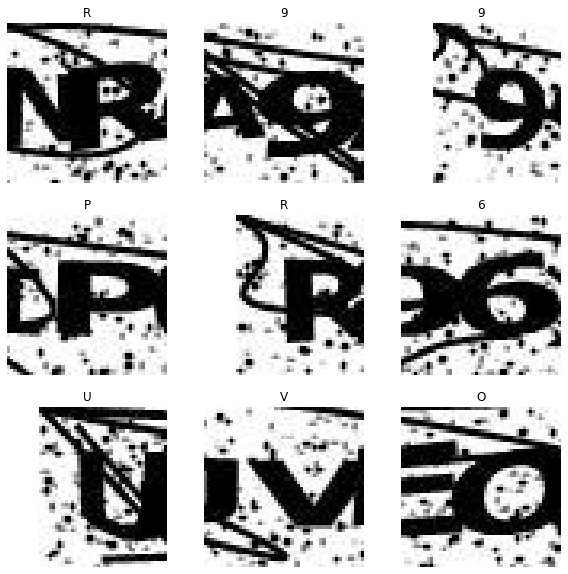

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Definindo o modelo

In [47]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
layers.Dense(num_classes)
])

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Resumo do Modelo

Temos primeiramente uma layer de rescaling, para transformar os valores entre 255 e 0 em valores entre 1 e 0.

Após isso temos 3 camadas convolucionais com um Max Pooling após elas para diminuir o tamanho e, após isso, temos um Dropout de 0.2 para evitar Overfitting.

Por fim utilizamos uma camada Flatten e duas camadas Densas para fazer a classificação.

In [49]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 25, 25, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 12, 12, 64)       

In [50]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
2992/2992 [==============================] - 32s 11ms/step - loss: 0.3355 - accuracy: 0.9056 - val_loss: 0.1342 - val_accuracy: 0.9630
Epoch 2/5
2992/2992 [==============================] - 33s 11ms/step - loss: 0.1093 - accuracy: 0.9681 - val_loss: 0.1338 - val_accuracy: 0.9616
Epoch 3/5
2992/2992 [==============================] - 32s 11ms/step - loss: 0.0799 - accuracy: 0.9749 - val_loss: 0.1391 - val_accuracy: 0.9648
Epoch 4/5
2992/2992 [==============================] - 32s 11ms/step - loss: 0.0601 - accuracy: 0.9802 - val_loss: 0.1375 - val_accuracy: 0.9690
Epoch 5/5
2992/2992 [==============================] - 32s 11ms/step - loss: 0.0473 - accuracy: 0.9839 - val_loss: 0.1545 - val_accuracy: 0.9675


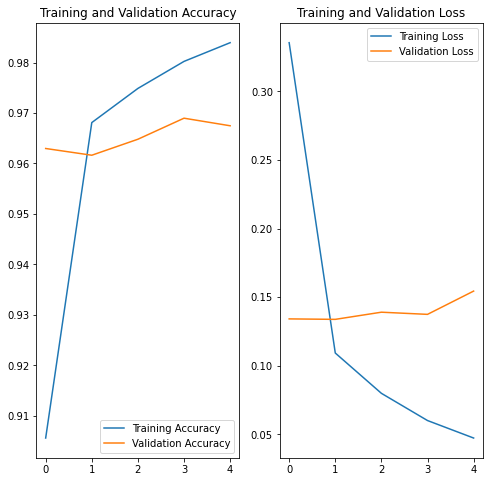

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

Vamos ver como o modelo se sai predizendo algumas imagens que ele nunca viu antes.

Classe: 0


<Figure size 432x288 with 0 Axes>

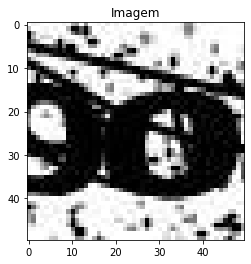

1/1 [==============================] - 0s 12ms/step
Classe Predita: 0
Confiança: 96.52697443962097




Classe: 1


<Figure size 432x288 with 0 Axes>

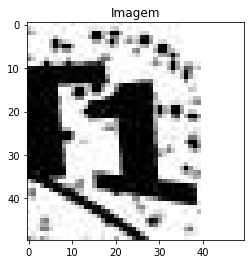

1/1 [==============================] - 0s 11ms/step
Classe Predita: 1
Confiança: 99.9927282333374




Classe: 2


<Figure size 432x288 with 0 Axes>

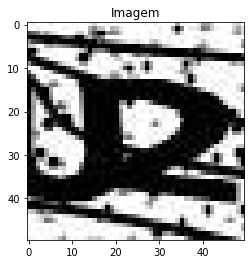

1/1 [==============================] - 0s 12ms/step
Classe Predita: 2
Confiança: 99.64620471000671




Classe: 3


<Figure size 432x288 with 0 Axes>

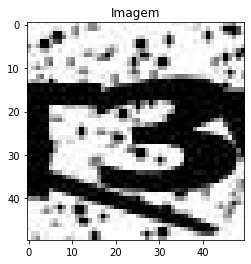

1/1 [==============================] - 0s 11ms/step
Classe Predita: 3
Confiança: 100.0




Classe: 4


<Figure size 432x288 with 0 Axes>

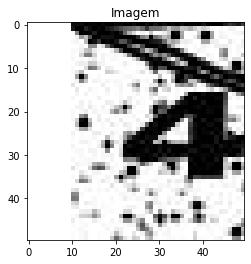

1/1 [==============================] - 0s 12ms/step
Classe Predita: 4
Confiança: 100.0




Classe: 5


<Figure size 432x288 with 0 Axes>

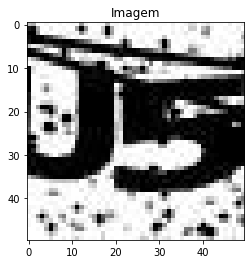

1/1 [==============================] - 0s 12ms/step
Classe Predita: 5
Confiança: 99.99980926513672




Classe: 6


<Figure size 432x288 with 0 Axes>

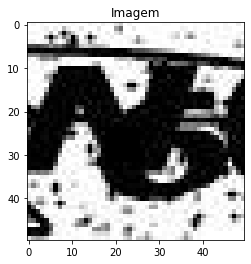

1/1 [==============================] - 0s 12ms/step
Classe Predita: 6
Confiança: 60.553085803985596




Classe: 7


<Figure size 432x288 with 0 Axes>

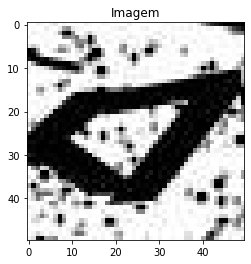

1/1 [==============================] - 0s 16ms/step
Classe Predita: 7
Confiança: 100.0




Classe: 8


<Figure size 432x288 with 0 Axes>

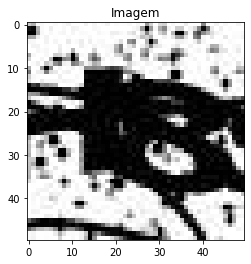

1/1 [==============================] - 0s 12ms/step
Classe Predita: 8
Confiança: 74.0973711013794




Classe: 9


<Figure size 432x288 with 0 Axes>

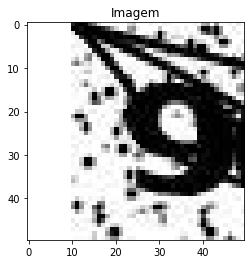

1/1 [==============================] - 0s 12ms/step
Classe Predita: 9
Confiança: 99.98096823692322




Classe: A


<Figure size 432x288 with 0 Axes>

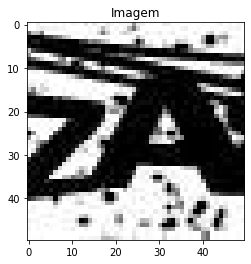

1/1 [==============================] - 0s 11ms/step
Classe Predita: A
Confiança: 100.0




Classe: B


<Figure size 432x288 with 0 Axes>

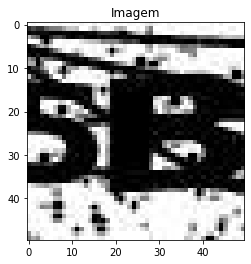

1/1 [==============================] - 0s 12ms/step
Classe Predita: B
Confiança: 100.0




Classe: C


<Figure size 432x288 with 0 Axes>

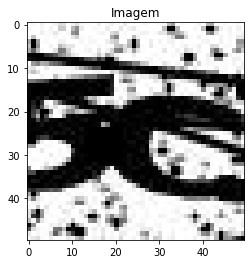

1/1 [==============================] - 0s 13ms/step
Classe Predita: C
Confiança: 99.99325275421143




Classe: D


<Figure size 432x288 with 0 Axes>

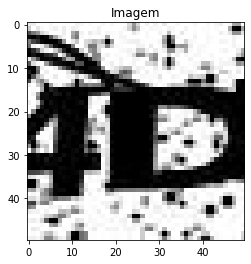

1/1 [==============================] - 0s 11ms/step
Classe Predita: D
Confiança: 100.0




Classe: E


<Figure size 432x288 with 0 Axes>

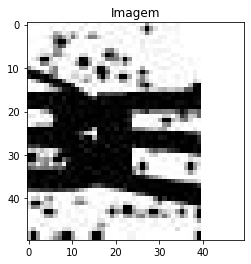

1/1 [==============================] - 0s 16ms/step
Classe Predita: E
Confiança: 99.99902248382568




Classe: F


<Figure size 432x288 with 0 Axes>

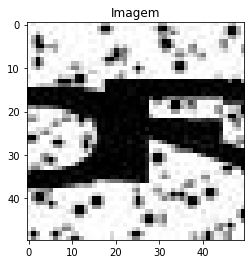

1/1 [==============================] - 0s 14ms/step
Classe Predita: F
Confiança: 99.9860167503357




Classe: G


<Figure size 432x288 with 0 Axes>

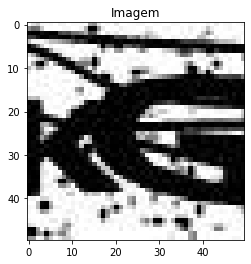

1/1 [==============================] - 0s 12ms/step
Classe Predita: G
Confiança: 99.99998807907104




Classe: H


<Figure size 432x288 with 0 Axes>

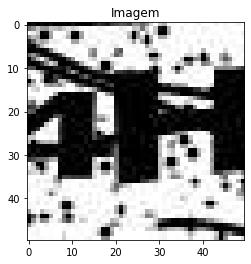

1/1 [==============================] - 0s 16ms/step
Classe Predita: H
Confiança: 100.0




Classe: I


<Figure size 432x288 with 0 Axes>

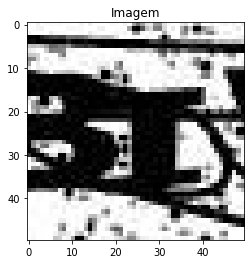

1/1 [==============================] - 0s 13ms/step
Classe Predita: I
Confiança: 98.25631380081177




Classe: J


<Figure size 432x288 with 0 Axes>

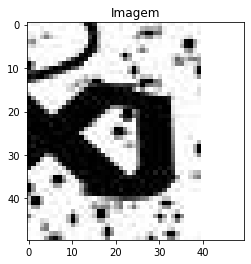

1/1 [==============================] - 0s 14ms/step
Classe Predita: J
Confiança: 99.99998807907104




Classe: K


<Figure size 432x288 with 0 Axes>

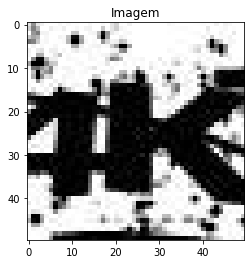

1/1 [==============================] - 0s 12ms/step
Classe Predita: K
Confiança: 99.99996423721313




Classe: L


<Figure size 432x288 with 0 Axes>

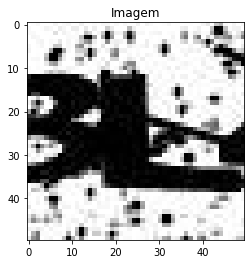

1/1 [==============================] - 0s 13ms/step
Classe Predita: L
Confiança: 99.99964237213135




Classe: M


<Figure size 432x288 with 0 Axes>

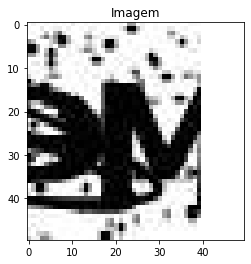

1/1 [==============================] - 0s 12ms/step
Classe Predita: M
Confiança: 99.99394416809082




Classe: N


<Figure size 432x288 with 0 Axes>

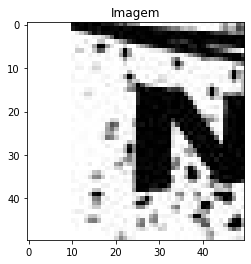

1/1 [==============================] - 0s 16ms/step
Classe Predita: N
Confiança: 99.99998807907104




Classe: O


<Figure size 432x288 with 0 Axes>

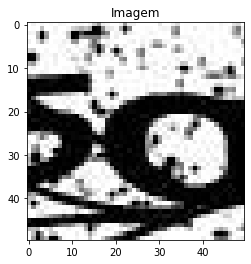

1/1 [==============================] - 0s 12ms/step
Classe Predita: Q
Confiança: 96.40204310417175




Classe: P


<Figure size 432x288 with 0 Axes>

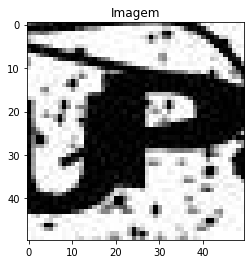

1/1 [==============================] - 0s 12ms/step
Classe Predita: P
Confiança: 99.9976634979248




Classe: Q


<Figure size 432x288 with 0 Axes>

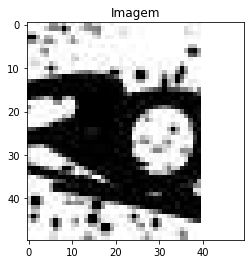

1/1 [==============================] - 0s 12ms/step
Classe Predita: Q
Confiança: 99.94508624076843




Classe: R


<Figure size 432x288 with 0 Axes>

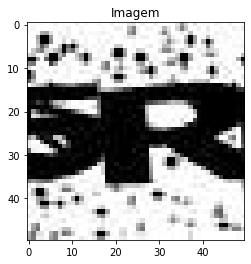

1/1 [==============================] - 0s 12ms/step
Classe Predita: R
Confiança: 100.0




Classe: S


<Figure size 432x288 with 0 Axes>

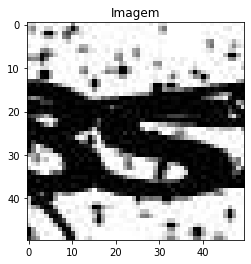

1/1 [==============================] - 0s 12ms/step
Classe Predita: S
Confiança: 99.95469450950623




Classe: T


<Figure size 432x288 with 0 Axes>

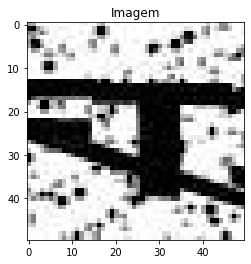

1/1 [==============================] - 0s 12ms/step
Classe Predita: T
Confiança: 99.99992847442627




Classe: U


<Figure size 432x288 with 0 Axes>

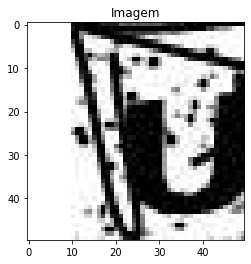

1/1 [==============================] - 0s 11ms/step
Classe Predita: U
Confiança: 99.99994039535522




Classe: V


<Figure size 432x288 with 0 Axes>

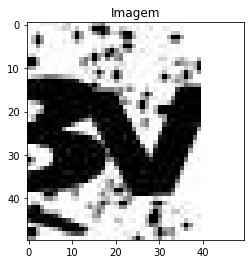

1/1 [==============================] - 0s 13ms/step
Classe Predita: V
Confiança: 99.86563920974731




Classe: W


<Figure size 432x288 with 0 Axes>

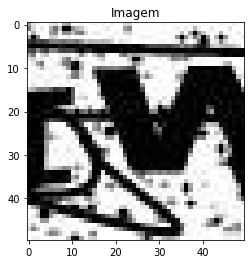

1/1 [==============================] - 0s 13ms/step
Classe Predita: W
Confiança: 98.01369309425354




Classe: X


<Figure size 432x288 with 0 Axes>

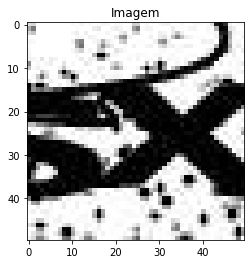

1/1 [==============================] - 0s 13ms/step
Classe Predita: X
Confiança: 100.0




Classe: Y


<Figure size 432x288 with 0 Axes>

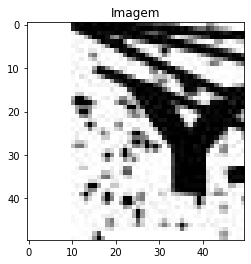

1/1 [==============================] - 0s 13ms/step
Classe Predita: Y
Confiança: 100.0




Classe: Z


<Figure size 432x288 with 0 Axes>

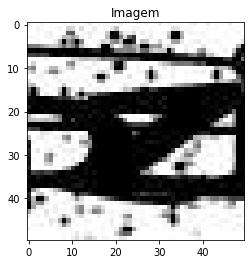

1/1 [==============================] - 0s 11ms/step
Classe Predita: Z
Confiança: 99.99997615814209






In [68]:
for c in class_names:
    print("Classe:", c)
    img_path = "../gen_data/teste/"+c+"/0001.png"
    
    src_img = cv2.imread(img_path, 0)
    show(src_img)
    
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print("Classe Predita:", class_names[np.argmax(score)])
    print("Confiança:", 100 * np.max(score))
    print("\n\n\n")